# Mini-Project: Palmer Penguins
_Group 24: Ziwei Li, Yilia Zhao, Shiyu Ma_

## Introduction

It is important to catalog the different species of penguins in Antarctica for scientific analysis. However, this often requires strenuous work that includes a combination of biological expertise and many precise measurements.

In this project, we will use an easier way to help determine the penguin species. We will explore the Palmer Penguins Data set collected by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER and apply machine learning models to figure out the species based on several selected features.

## Group Contribution Statement

In this project, all three of us worked together in the exploratory analysis part. We observed the relationships between different variables and determined the prospective features to use in the models. Ziwei made a great contribution in clearing the raw data, and spliting the data into training and test sets. She also led on the first model - the Decision Tree model. Shiyu led on the second model - the Multinomial Logistic Regression model. Yilia led on the third model - the K-Nearest-Neighbor Classifiers model. Then, we discussed and interpreted the performances of the three models. Finally, we worked together to finish the docstrings and comments of our codes, and we modified our project into a well-organized notebook as well.

## §1. Loading and Preparing our data

### Standard Import

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import tree, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

Starting with loading the penguin data, we changed the Species name to only get the first word of the species so that our data is easier to read.

In this case, we get __Adelie, Chinstrap__, and __Gentoo__ for all the penguin species.
Here are some example data:

In [2]:
url = 'https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv'
penguins = pd.read_csv("palmer_penguins.csv")

#shorten the species name
penguins["Species"] = penguins["Species"].str.split().str.get(0)
#clear data that doesn't make sense
penguins=penguins[(penguins["Sex"]=="MALE") | (penguins["Sex"]=="FEMALE")]
penguins.head(6)

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
4,PAL0708,5,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN
5,PAL0708,6,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N3A2,Yes,11/16/07,39.3,20.6,190.0,3650.0,MALE,8.66496,-25.29805,NaN
6,PAL0708,7,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N4A1,No,11/15/07,38.9,17.8,181.0,3625.0,FEMALE,9.18718,-25.21799,Nest never observed with full clutch.


## §2. Exploratory Analysis

In this section, we explored the penguin data using summary tables and plots. We would use our observations on the relationships between variables to make modeling decisions in the modeling section.

### Scatterplot by species

First of all, we created a scatterplot with __Culmen length__ on the x-axis and __Culmen depth__ on the y-axis. Each specie is represented in a distinct color.

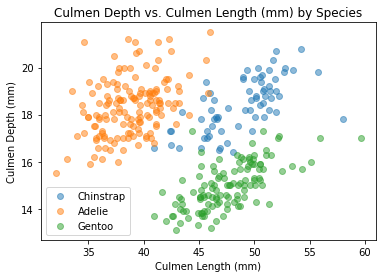

In [3]:
fig, ax = plt.subplots(1)
ax.set(xlabel = "Culmen Length (mm)",
       ylabel = "Culmen Depth (mm)",
      title="Culmen Depth vs. Culmen Length (mm) by Species") #set x,y axis name

species=set(penguins["Species"]) #get all types of species

for s in species:
    only=penguins[penguins["Species"]==s] #for a given species
    #plot its length~depth
    #label=s.split(' ')[0] get the first word in species name
    ax.scatter(only["Culmen Length (mm)"],only["Culmen Depth (mm)"],label=s.split(' ')[0],alpha=0.5)

ax.legend() #add legend as label specified above


From the graph above, we can see that Adelie penguins on average have relatively shorter Culmen Length (< 45mm approximately) compared to that of the other two species. Also, Gentoo penguins have relatively smaller Culmen Depth (<17 mm approximately). These two features may be helpful to determine the species in later analysis.

### Body Mass histogram

Second, we made a histogram of __Body Mass__ of different species to see their distributions. This graph might allow us to inspect the relationship between body masses and different species.

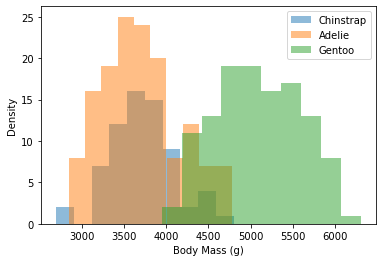

In [4]:
fig, ax = plt.subplots(1)
ax.set(xlabel = "Body Mass (g)",
       ylabel = "Density") #set x,y axis name

species=set(penguins["Species"]) #get all types of species

for s in species:
    only=penguins[(penguins["Species"]==s)] #for a given species
    only=only["Body Mass (g)"].dropna()
    if only.empty:continue #avoid error
    ax.hist(only,label=s,alpha=.5)
ax.legend() #add legend, not in loop


From this graph, we can see that Gentoo penguins have relatively higer body masses than the other two species. However, Adelie and Chinstrap penguins have similar body masses which indicates that we might need other features to distinguish these two species.

### Boxplots of Culmen Length and Culmen Depth (Classified by Sex and Species)

Next, we expected the variable sex is related to different species. Here we created two boxplots to see the different ranges of Culmen lengths and Culmen Depths for species in two sexes.

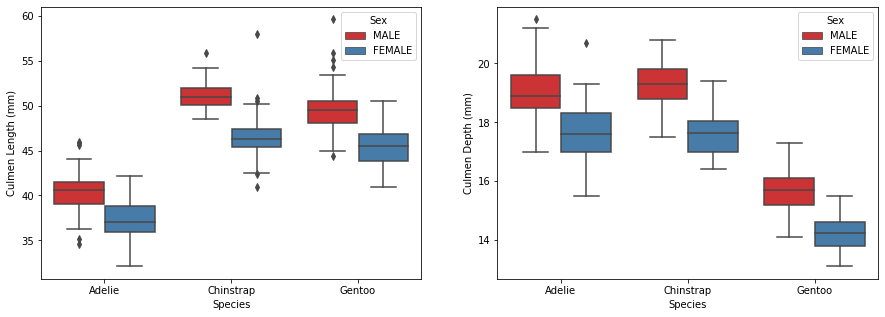

In [5]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False) #create two empty subplots

#two boxplots of culmen length and culmen depth
sns.boxplot(ax=axes[0],x="Species", y="Culmen Length (mm)", hue="Sex", data=penguins, palette="Set1")
sns.boxplot(ax=axes[1],x="Species", y="Culmen Depth (mm)", hue="Sex", data=penguins, palette="Set1")
plt.show()

From the two plots above, we could tell that the culmen lengths of male penguins are always higher that those of the female penguins. Also, the culmen lengths of Adelie penguins are lower than those of the other two species. In addition, the culmen depths of Adelie penguins are higher than those of the other two species.   

We also observed some outliers that are presented as dots in the graphs. These outliers might cause some false predictions since they overlap with the ranges of the other species' data.

### Tables with Different Selections of Variables

In this section, we will use tables to further explore the relationships between species and different variables for the following machine learning analysis.

First, we wrote a function to better systematically construct summary tables for different groups of penguins with specified variables.

In [6]:
def penguin_summary_table(group_cols,value_cols):
    '''
    Construct a data for the specified groups of penguins
    input:
    group_cols - the penguins we would like to group by
    value_cols - data of the grouped penguins we would like to observe
    --------
    output:
    a summary table for the specified penguins
    '''
    #value_cols is a list, no need double []
    return penguins.groupby(group_cols)[value_cols].mean().round(2) 

### Table with a lot of columns

To begin with, we included many variables that we considered relevant in determing the species to observe the potential useful features for the following models.

In [7]:
penguin_summary_table(["Island","Sex","Species"], 
                      ["Culmen Length (mm)","Culmen Depth (mm)",
                        "Flipper Length (mm)", "Body Mass (g)",
                       "Delta 15 N (o/oo)","Delta 13 C (o/oo)"])

Culmen Length (mm)  Culmen Depth (mm)  \
Island    Sex    Species                                            
Biscoe    FEMALE Adelie                  37.36              17.70   
                 Gentoo                  45.56              14.24   
          MALE   Adelie                  40.59              19.04   
                 Gentoo                  49.47              15.72   
Dream     FEMALE Adelie                  36.91              17.62   
                 Chinstrap               46.57              17.59   
          MALE   Adelie                  40.07              18.84   
                 Chinstrap               51.09              19.25   
Torgersen FEMALE Adelie                  37.55              17.55   
          MALE   Adelie                  40.59              19.39   

                            Flipper Length (mm)  Body Mass (g)  \
Island    Sex    Species                                         
Biscoe    FEMALE Adelie                  187.18        3369.32   
                 Gentoo                  212.71        4679.74   
          MALE   Adelie                  190.41        4050.00   
                 Gentoo                  221.54        5484.84   
Dream     FEMALE Adelie                  187.85        3344.44   
                 Chinstrap               191.74        3527.21   
          MALE   Adelie                  191.93        4045.54   
                 Chinstrap               199.91        3938.97   
Torgersen FEMALE Adelie                  188.29        3395.83   
          MALE   Adelie                  194.91        4034.78   

                            Delta 15 N (o/oo)  Delta 13 C (o/oo)  
Island    Sex    Species                                          
Biscoe    FEMALE Adelie                  8.77             -25.92  
                 Gentoo                  8.19             -26.20  
          MALE   Adelie                  8.87             -25.92  
                 Gentoo                  8.30             -26.17  
Dream     FEMALE Adelie                  8.91             -25.74  
                 Chinstrap               9.25             -24.57  
          MALE   Adelie                  8.98             -25.76  
                 Chinstrap               9.46             -24.53  
Torgersen FEMALE Adelie                  8.66             -25.74  
          MALE   Adelie                  8.92             -25.84

From the table above, we can see that for all penguins with different species, sexes and Islands, their data for Delta 15, Delta 13, and Flipper Length seem to be similar. Thus we can get rid of these three columns to prevent overfitting brought by including the random noises.

### Table with helpful columns

In [8]:
# Improved Table
penguin_summary_table(["Island","Species","Sex"], 
                      ["Culmen Length (mm)","Culmen Depth (mm)",
                       "Body Mass (g)"])


Culmen Length (mm)  Culmen Depth (mm)  \
Island    Species   Sex                                             
Biscoe    Adelie    FEMALE               37.36              17.70   
                    MALE                 40.59              19.04   
          Gentoo    FEMALE               45.56              14.24   
                    MALE                 49.47              15.72   
Dream     Adelie    FEMALE               36.91              17.62   
                    MALE                 40.07              18.84   
          Chinstrap FEMALE               46.57              17.59   
                    MALE                 51.09              19.25   
Torgersen Adelie    FEMALE               37.55              17.55   
                    MALE                 40.59              19.39   

                            Body Mass (g)  
Island    Species   Sex                    
Biscoe    Adelie    FEMALE        3369.32  
                    MALE          4050.00  
          Gentoo    FEMALE        4679.74  
                    MALE          5484.84  
Dream     Adelie    FEMALE        3344.44  
                    MALE          4045.54  
          Chinstrap FEMALE        3527.21  
                    MALE          3938.97  
Torgersen Adelie    FEMALE        3395.83  
                    MALE          4034.78

Through "Eye-balling", we first get the table above with Island, Sex, Culmen Length, Culmen Depth, and Body Mass as the most helpful variables that can help determine the species. We will use systematic feature selection later in the Modeling section to continue exploring the useful features for specific models.

## §3. ML Modeling

In this section, we will use __1.Decision Tree__, __2.Multinomial Logistic Regression__, and __3.K-Nearest-Neighbor Classifiers__ as our models for data analysis.

For our Machine Learning Model, we first need to split our penguins data into __training__ and __test sets__. Here we get 80% of the data to be our training data set that will be useful for our model training and the remaining 20% to be the testing data set.

In [9]:
train,test=train_test_split(penguins,test_size=.2)
train.shape,test.shape

((266, 17), (67, 17))

### Data Cleaning
For data cleaning and other preparation, we wrote a function `prep_penguins_data` to drop several columns of data that we have considered to be not helpful to our training indicated in our previous Exploratory Analysis. Also, we drop the rows with missing information to prevent running in any issues with our data.


In [10]:
def prep_penguins_data(data_df):
    '''
    This function is to prepare and clean the predictor and target datasets 
    to help our machine-learning models with interpreting the data. 
    It will return valid predictor dataset X and target dataset y in machine-
    readable number formats.

    '''
    df = data_df.copy() #create a copy of the input data
    #drop uncessary columns based on previous exploratory analysis
    df=df.drop(["studyName","Sample Number","Individual ID","Comments",
                "Region","Stage","Date Egg","Clutch Completion"],axis=1)
    df=df.dropna() #get rid of missing data
    
    le = preprocessing.LabelEncoder() 
    #transform text data into machine readable numbers
    df['Sex'] = le.fit_transform(df['Sex'])
    df['Species']=le.fit_transform(df['Species'])
    df['Island']=le.fit_transform(df['Island'])
    
    #Set predictor variables X and target variable y
    X = df.drop(["Species"], axis = 1)
    y = df["Species"]
        
    return(X, y)


Next, in order to predict the species of the penguins given our datasets, we need to split the data into the "predictor" and "target" variables.

In [11]:
#preparing train and test datasets
X_train, y_train = prep_penguins_data(train)
X_test,  y_test  = prep_penguins_data(test)

### Feature Selection Function

In our previous Exploratory Analysis, we have discovered a few columns that might be useful in predicting the species of the penguins. Here we put the potential columns such as Culmen Length (mm), Culmen Depth (mm), Sex, Island, Body Mass (g) in different combinations with each other into a list called combos.

Since the Cross-Validation applies unseen data to the model, it could accurately and fairly evaluate the performance of the model. By using __K-fold Cross-Validation__, we repeatly assign different data into our test set to evaluate our model. We then wrote a function which uses __cross-validation__ to find the best combination of the columns that has the highest __cross-validation__ score.

In [12]:
def check_column_score(model):
    """
    Trains and evaluates the model via cross-validation on the different combos
    of columns
    ------------
    Input:
    model - the classifier we use
    ------------
    Output:
    best_com - the best combo of features
    """
    #different combinations of features
    combos = [['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'],
          ['Sex', 'Culmen Length (mm)', 'Body Mass (g)'],
          ['Island', 'Body Mass (g)','Culmen Length (mm)'],
          ['Body Mass (g)', 'Culmen Length (mm)', 'Culmen Depth (mm)'],
              ['Sex', 'Island', 'Body Mass (g)'],
          ['Sex', 'Island', 'Culmen Depth (mm)'],
             ['Body Mass (g)','Culmen Depth (mm)','Sex']]
    
    best_score=0 #initialize best_score to be 0
    #loop through all the combinations
    for combo in combos:
        x=cross_val_score(model,X_train[combo],y_train,cv=5).mean()
        x=np.round(x,3)
        print("CV score is "+str(x))
        print("training with columns"+str(combo))
        
        #update the best_score
        if x > best_score:
            best_com = combo
            best_score = x
        
    return best_com

## Model 1: Decision Tree 

Let's start with our first model - Decision Tree. The Decision Tree model is a supervised learning method used for classification and regression. It analyzes data and create a set of simple decision rules to predict the value of a target variable.

In [13]:
T=tree.DecisionTreeClassifier(max_depth=3)#set decision tree model

### Feature Selection

Here, we will call our pre-written ___check_column_score___ function to do our feature selection in a systematic way. We will test the performance of potential groups of predicators and select the best group with the highest ___cross-validation score___ for our Decision Tree model.

In [14]:
best_combo=check_column_score(T) #check cv scores for all the groups

CV score is 0.935
training with columns['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex']
CV score is 0.9
training with columns['Sex', 'Culmen Length (mm)', 'Body Mass (g)']
CV score is 0.969
training with columns['Island', 'Body Mass (g)', 'Culmen Length (mm)']
CV score is 0.958
training with columns['Body Mass (g)', 'Culmen Length (mm)', 'Culmen Depth (mm)']
CV score is 0.781
training with columns['Sex', 'Island', 'Body Mass (g)']
CV score is 0.796
training with columns['Sex', 'Island', 'Culmen Depth (mm)']
CV score is 0.781
training with columns['Body Mass (g)', 'Culmen Depth (mm)', 'Sex']


According to the results shown above, our best combination of predicators with the highest cv_score 0.969 is _Island_, _Body Mass (g)_, and _Culmen Length (mm)_. We will use this group to continue training our model.

In [15]:
X_train1=X_train[best_combo] #Set training data with the best combo
X_test1=X_test[best_combo] #Set test data with the best combo
T.fit(X_train1,y_train) #fit the model

DecisionTreeClassifier(max_depth=3)

### Determine Model Complexity

Next, to find the optimal complexity parameter `max_depth` that will be used in our model, we employed the ___cross-validation___ method in order to choose the best `max_depth` with the highest cross-validation score.

0.9692307692307691 3


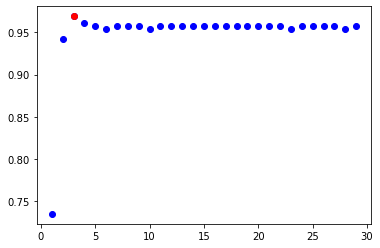

In [16]:
best_score, best_para = 0, 0 
fig,ax=plt.subplots(1)
# loop through different complexity parameter n_neighbors
for d in range(1, 30):
    T = tree.DecisionTreeClassifier(max_depth=d) # initialize the KNN Model
    
    # compute mean of cv score
    cv_score = cross_val_score(T, X_train1, y_train, cv = 5).mean() 
    ax.scatter(d, cv_score, color = "blue") # plot this point on the graph
    
    
    # if the current cv score is greater than best_score, update best_score
    if cv_score > best_score:
        best_para = d
        best_score = cv_score

#Visualize the parameters and corresponding cv scores      
ax.scatter(best_para, best_score, color = "red") #shown the best one in red
print(best_score, best_para)


From our graph and score shown above, we get our best `max_depth` of 3 with a cross-validation score of 0.969. We will then use this parameter for training our Decision Tree model.

### Evaluate Model on the Test Data

In [17]:
#establish our model with the best parameter
T=tree.DecisionTreeClassifier(max_depth=best_para) 
T.fit(X_train1,y_train) #fit model with training data
T.score(X_test1,y_test) #score model on the test data

0.953125

Here we get a score of around 0.953. This is a pretty good result showing that our Decision Tree model is able to predict most of the species correctly. This score is slightly lower but not significantly lower than that of the training data, showing that there might be no overfitting occurred in our model.

Next, let's Visualize our decision tree using the `plot_tree` function:

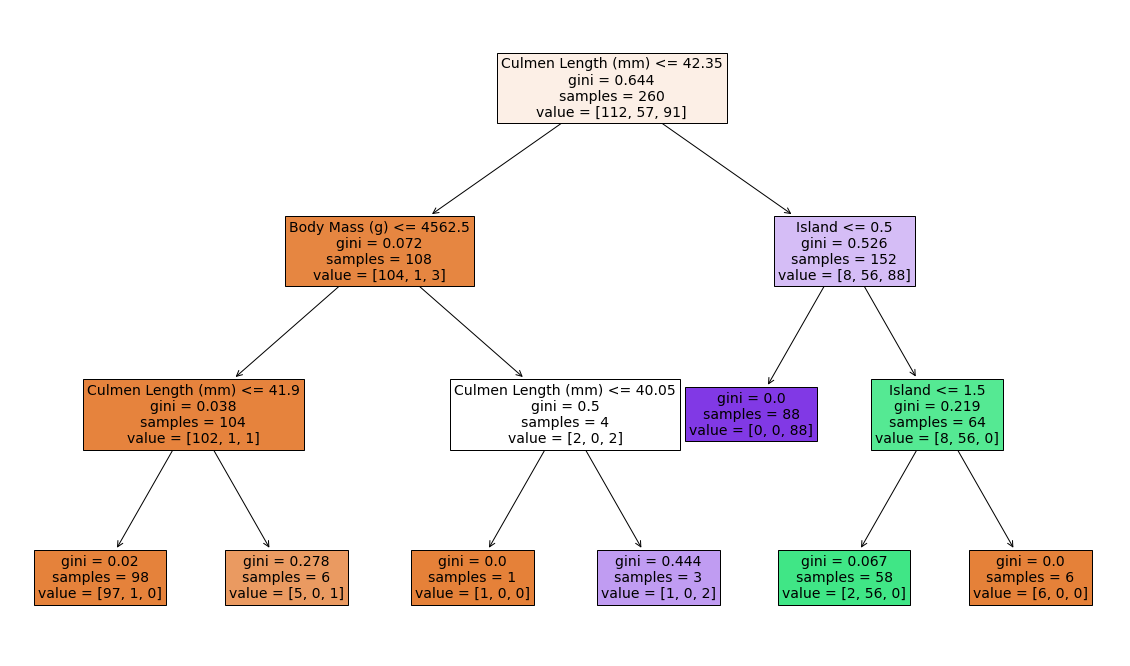

In [22]:
fig,ax=plt.subplots(1,figsize=(20,12)) #create an empty plot
graph=tree.plot_tree(T,filled=True, feature_names=X_test1.columns, fontsize=14)

The graph above shows the pathways that our model will take to make certain decisions. We can see that it will first check if Culmen Length is <= to 42.35mm. If the Culmen Length satisfies the condition, it will then check if its Body Mass is <= to 4562.5. Otherwise, it will check if the Island is <= 0.5. In this case, our model will check the conditions in the box and choose its pathways following the arrows. In the end, our model will make its final predictions of the penguin species based on the multiple criteria shown in the boxes.

### Inspecting Errors

Next, we will inspect some of the wrong predictions of the testing data results by using a confusion matrix.

In [24]:
y_test_pred=T.predict(X_test1) #create a variable to store the predictions
c=confusion_matrix(y_test,y_test_pred) #plot the confusion matrix
c

array([[24,  0,  3],
       [ 0, 10,  0],
       [ 0,  0, 27]], dtype=int64)

The __i, j__th entry of the confusion matrix array above gives the number of times that the model predicted specie j when the true specie was actually i.

Thus each row of the array represents the actual Species of penguins, where row 1 is an Adelie, 2 is a Chinstrap, and 3 is a Gentoo. Each columns represents the predicted Species of penguins, where columns 1, 2, 3 indicates Species with the same order above.

From the confusion matrix, we could see that large numbers are on the diagonal and this indicates the model is usually right. However, the [0,2]th entry is 3. This number corresponds to the false predictions shown above: 3 specie-0 penguins(Adelie) were falsely predicted as specie-2 penguins(Gentoo).

Let's take a look at some of these cases using Boolean indexing:

In [25]:
mask=y_test!=y_test_pred #filter all wrong predictions

#wrong result's predictor
mistakes=X_test1[mask][["Culmen Length (mm)","Island","Body Mass (g)"]]  

mistake_preds=y_test_pred[mask] #wrong result
true_specie=y_test[mask] #actural result

mistake_preds,true_specie #print wrong result vs actural result

(array([2, 2, 2]),
 111    0
 115    0
 109    0
 Name: Species, dtype: int32)

Here we can see the specific entries that were falsely predicted. Let's reframe the data in a clearer table to figure out why our model was "tricked".

In [26]:
mistake_df=pd.DataFrame({"True Species":true_specie,"Wrong Prediction":mistake_preds})
mistake_table=pd.concat((mistake_df,mistakes),axis=1)

#Match numbers to text information
decode={0:'Adelie',1:'Chinstrap',2:'Gentoo'}
decode1={0:'Biscoe',1:'Dream',2:'Torgersen'}

#show readable text format to readers
mistake_table["True Species"]=mistake_table["True Species"].map(decode)
mistake_table["Wrong Prediction"]=mistake_table["Wrong Prediction"].map(decode)
mistake_table["Island"]=mistake_table["Island"].map(decode1)

mistake_table

,True Species,Wrong Prediction,Culmen Length (mm),Island,Body Mass (g)
111,Adelie,Gentoo,45.6,Biscoe,4600.0
115,Adelie,Gentoo,42.7,Biscoe,4075.0
109,Adelie,Gentoo,43.2,Biscoe,4775.0


Now let's see the variable means of the three species. 

In [55]:
train.groupby(["Species","Island"])[["Culmen Length (mm)","Body Mass (g)"]].mean()

Culmen Length (mm)  Body Mass (g)
Species   Island                                      
Adelie    Biscoe              39.002941    3648.529412
          Dream               38.676087    3723.913043
          Torgersen           39.294737    3713.815789
Chinstrap Dream               48.752632    3714.912281
Gentoo    Biscoe              47.590110    5115.934066

Compare the variable values of the falsely predicted data with the variable means above, we can see that some penguins have values of Culmen Length, Culmen Depth that are similar to those of other species. 

For example, penguin 111 is a Adelie penguin living on Biscoe island. However, it has Culmen Length of 45.60mm, which is closer to 47.59mm (Gentoo penguins living on Biscoe island) rather than the Culmen Length of the species that it belongs to. In this case, our model falsely predicted it as a Gentoo penguin.

## Model 2: Multinomial Logistic Regression

For our second model, we will use Multinomial Logistic Regression. The model is an extension of the binary logistic regression. It uses maximum likelihood estimation to evaluate the probability of categorical membership for more than two categories of the dependent or outcome variable.

We set 'max_iter' to 500 to avoid error and keep rest of parameters as default. By using the same method above (call function `check_column_score`), we select the best combo of predictors that gives us the best cross-validation score.

In [29]:
LR=LogisticRegression(max_iter=1000,multi_class='multinomial', solver='lbfgs')
best_combo=check_column_score(LR)

CV score is 0.988
training with columns['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex']
CV score is 0.965
training with columns['Sex', 'Culmen Length (mm)', 'Body Mass (g)']
CV score is 0.962
training with columns['Island', 'Body Mass (g)', 'Culmen Length (mm)']
CV score is 0.988
training with columns['Body Mass (g)', 'Culmen Length (mm)', 'Culmen Depth (mm)']
CV score is 0.685
training with columns['Sex', 'Island', 'Body Mass (g)']
CV score is 0.765
training with columns['Sex', 'Island', 'Culmen Depth (mm)']
CV score is 0.781
training with columns['Body Mass (g)', 'Culmen Depth (mm)', 'Sex']


There are two combos achieve the same cv score 0.988 and we decide to choose the best_combo as `['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex']`

Before tune the parameter in model, we modify our training data according to the feature we have selected.

In [30]:
X_train2=X_train[best_combo]
X_test2=X_test[best_combo]

The C parameter controls the regularization (penality) strength and smaller values specify stronger regularization. Since it must be a positive float, we try different C from 0.01 to 100.

0.9884615384615385 1


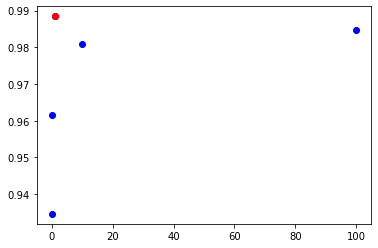

In [31]:
best_score, best_para = 0, 0 
fig,ax=plt.subplots(1)
# loop through different complexity parameter C
for d in [0.01,0.1,1,10,100]:
    # initialize the Multonomial Logistics Regression Model
    LR = LogisticRegression(C=d,max_iter=5000,multi_class='multinomial')
    
    # compute mean of cv score
    cv_score = cross_val_score(LR, X_train2, y_train, cv = 5).mean() 
    ax.scatter(d, cv_score, color = "blue") # plot this point on the graph
    
    
    # if the current cv score is greater than best_score, update best_score
    if cv_score > best_score:
        best_para = d
        best_score = cv_score
        
ax.scatter(best_para, best_score, color = "red")
print(best_score, best_para)

By looking at the graph as well as our result for the optimal, here we get `C` = 1 to be the best complexity parameter. We then set our Multinomial Logistic Regression model using this information.

In [32]:
LR=LogisticRegression(C=best_para,max_iter=500,multi_class='multinomial', solver='lbfgs')
LR.fit(X_train2,y_train)
LR.score(X_test2,y_test)

1.0

By evaluating our model against the unseen testing data, we gain an accuracy of 1.0, which is a very good result. It is even higher than the cv score in our train set but the difference is not super huge.

### Plot Decision Regions

In order to better visualize our modeling predictions in a systematic way, we have written a `plot_regions` function below. We will later call this function in our individual models.

In [34]:
def plot_regions(c,X,y):
    """
    Plot the decision regions of a classifer
    c: the classifier
    X: the data frame with all three columns of predictor variables (sex, culmen 
    length, culment depth)
    y: the target variable which contains the column "Species"
    
    Outputs
    -------
    Does not return any values.
    Plots the decision regions of the machine learning model on two sex groups.
    
    """
    
    #create an empty plot with two subplots
    fig, ax = plt.subplots(1,2,figsize=(10,4))

    #separate X and y into two sex groups: "_f" represents the female group; 
    #"_m" represents the male group
    mask_f=X["Sex"]==0
    X_f=X[mask_f]
    y_f=y[mask_f]
    mask_m=X["Sex"]==1
    X_m=X[mask_m]
    y_m=y[mask_m]

    #recode labels 
    le = preprocessing.LabelEncoder()        
    y_f= le.fit_transform(y_f)
    y_m= le.fit_transform(y_m)
    
    x0_f=X_f['Culmen Length (mm)']
    x1_f=X_f['Culmen Depth (mm)']
    x0_m=X_m['Culmen Length (mm)']
    x1_m=X_m['Culmen Depth (mm)']
    
    #create two grids for two sexes
    grid_x_f=np.linspace(x0_f.min(),x0_f.max(),501)
    grid_y_f=np.linspace(x1_f.min(),x1_f.max(),501)
    xx_f,yy_f=np.meshgrid(grid_x_f,grid_y_f) #has 501x501
    grid_x_m=np.linspace(x0_m.min(),x0_m.max(),501)
    grid_y_m=np.linspace(x1_m.min(),x1_m.max(),501)
    xx_m,yy_m=np.meshgrid(grid_x_m,grid_y_m)
    
    #make the sex column either zeros or ones
    male = np.zeros(251001)
    female = np.ones(251001)
    
    ##this part is for famale penguins
    #fit the female model
    c.fit(X_f,y_f)
    #convert columns to 1d arrays
    XX_f=xx_f.ravel()
    YY_f=yy_f.ravel()
    #use model to make predictions
    p_f=c.predict(np.c_[XX_f,YY_f,female])    
    #reshape the prediction to a 2d array
    p_f=p_f.reshape(xx_f.shape)
    #plot the decision regions for female penguins, color-coded by species
    ax[0].contourf(xx_f,yy_f,p_f,cmap="jet",alpha=.2)
    #plot the scatter plot for female penguins
    ax[0].scatter(x0_f,x1_f,c=y_f,cmap="jet")
    
    ##this part is for male penguins, similar to the code above
    c.fit(X_m,y_m)
    XX_m=xx_m.ravel()
    YY_m=yy_m.ravel()
    p_m=c.predict(np.c_[XX_m,YY_m,male])
    p_m=p_m.reshape(xx_m.shape)
    ax[1].contourf(xx_m,yy_m,p_m,cmap="jet",alpha=.2)
    ax[1].scatter(x0_m,x1_m,c=y_m,cmap="jet")
    
    #set labels to the plots
    ax[0].set(xlabel = "Culmen Length (mm)",
           ylabel = "Culmen Depth (mm)",
           title = "Female Penguins")
    ax[1].set(xlabel = "Culmen Length (mm)",
           ylabel = "Culmen Depth (mm)",
           title = "Male Penguins")

To show the predictions of our Multinomial Logistic Regression model, we use the `plot_regions` function below.

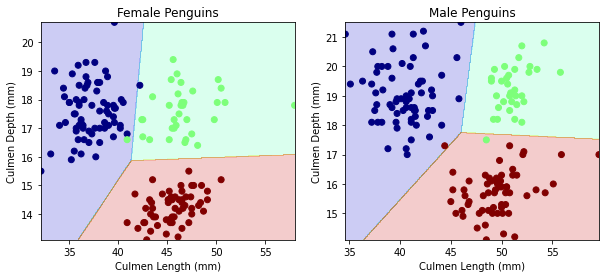

In [35]:
X,y=prep_penguins_data(penguins)
X2=X[best_combo]
plot_regions(LR,X2,y)

By observing the two graphs above, we could tell that our model has a high accuracy that it has successfully predicted the species of most penguins.

Some data points at boundary of decision regions is wrongly predicted. In the next section, we will inspect these errors and explore possible reasons.

### Inspecting Error

Like we did above for our Decision Tree model, we will use a __confusion matrix__ to help us inspect the errors in our prediction.

In [40]:
y_test_pred=LR.predict(X_test2) 

from sklearn.metrics import confusion_matrix
c=confusion_matrix(y_test,y_test_pred)
c

array([[27,  0,  0],
       [ 2,  4,  4],
       [ 0,  0, 27]], dtype=int64)

In the [1,0]th and [1,2]th entries, we got 6 wrong predictions in our model: 2 Chinstrap penguins were falsely predicted as Adelie and 4 Chinstrap penguins were falsely predicted as Gentoo. We will further explore these wrong data in Boolean indexing.

In [41]:
mask=y_test!=y_test_pred #filter all wrong predictions

#wrong result's predictor
mistakes=X_test[mask][["Culmen Length (mm)","Culmen Depth (mm)","Sex"]]  
mistake_preds=y_test_pred[mask] #wrong result
true_specie=y_test[mask] #actural result

mistake_preds,true_specie #print wrong result vs actural result

(array([2, 0, 2, 2, 2, 0], dtype=int64),
 208    1
 157    1
 164    1
 202    1
 201    1
 158    1
 Name: Species, dtype: int32)

Here we can see the index of the penguins that were predicted wrong. We will then convert the array into table formatting to better observe why our model would make these mistakes.

In [43]:
mistake_df=pd.DataFrame({"True Species":true_specie,"Wrong Prediction":mistake_preds})
mistake_table=pd.concat((mistake_df,mistakes),axis=1)

#Match numbers to text information
decode={0:'Adelie',1:'Chinstrap',2:'Gentoo'}
decode1={0:'FEMALE',1:'MALE'}

#show readable text format to readers
mistake_table["True Species"]=mistake_table["True Species"].map(decode)
mistake_table["Wrong Prediction"]=mistake_table["Wrong Prediction"].map(decode)
mistake_table["Sex"]=mistake_table["Sex"].map(decode1)
mistake_table

,True Species,Wrong Prediction,Culmen Length (mm),Culmen Depth (mm),Sex
208,Chinstrap,Gentoo,45.2,16.6,FEMALE
157,Chinstrap,Adelie,45.2,17.8,FEMALE
164,Chinstrap,Gentoo,47.0,17.3,FEMALE
202,Chinstrap,Gentoo,48.1,16.4,FEMALE
201,Chinstrap,Gentoo,49.8,17.3,FEMALE
158,Chinstrap,Adelie,46.1,18.2,FEMALE


We will then compare the individual data with the means of its corresponding group.

In [38]:
train.groupby(["Species","Sex"])[["Culmen Length (mm)","Culmen Depth (mm)"]].mean()

Culmen Length (mm)  Culmen Depth (mm)
Species   Sex                                          
Adelie    FEMALE           37.298305          17.645763
          MALE             40.640678          18.964407
Chinstrap FEMALE           46.634483          17.606897
          MALE             50.946429          19.135714
Gentoo    FEMALE           45.566667          14.214286
          MALE             49.324490          15.734694

For example, we have penguin 208 is a female Chinstrap penguin. However, it has Culmen Length of 45.2, which is closer to 45.57 (female Gentoo penguins) rather than 46.63 of the female Chinstrap penguins. In this case, our model falsely predicted its specie. 

## Model 3: K-Nearest-Neighbor Classifiers

For our third model, we will use K-Nearest-Neighbor model. The KNN model measures the similarity or proximity of data by calculating the distance between different points in the dataset. 


### Feature Selection

Since we have pre-written a `check_column_score` function in the previous section, we will call the function below to choose the best combination for our KNN model.

In [94]:
KNN=KNeighborsClassifier() #Set model
best_combo=check_column_score(KNN) #call check_column_score function

CV score is 0.973
training with columns['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex']
CV score is 0.773
training with columns['Sex', 'Culmen Length (mm)', 'Body Mass (g)']
CV score is 0.773
training with columns['Island', 'Body Mass (g)', 'Culmen Length (mm)']
CV score is 0.781
training with columns['Body Mass (g)', 'Culmen Length (mm)', 'Culmen Depth (mm)']
CV score is 0.731
training with columns['Sex', 'Island', 'Body Mass (g)']
CV score is 0.819
training with columns['Sex', 'Island', 'Culmen Depth (mm)']
CV score is 0.692
training with columns['Body Mass (g)', 'Culmen Depth (mm)', 'Sex']


From the results shown above, we therefore can choose our features as columns 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex' since it has the highest cross-validation score.

Since the Cross-Validation applies unseen data to the model, it could accurately and fairly evaluate the performance of the model. By using __K-fold Cross-Validation__, we repeatly assign different data into our test set to evaluate our model and get the mean CV score 0.973.

In [95]:
X_train3=X_train[best_combo] #Set our train and test data
X_test3=X_test[best_combo]


Next, to find the optimal complexity parameter `n_neightbors` that will be used in our KNN model, we also employed the ___cross-validation___ method below. 

0.9730769230769232 3


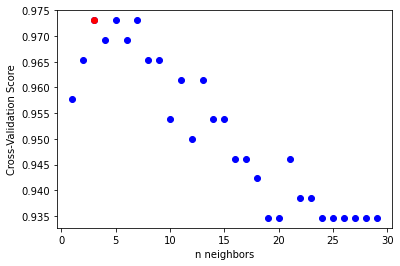

In [96]:
# Plot to visualize the cross validation scores over model complexity
fig, ax = plt.subplots(1) 
ax.set(xlabel = "n neighbors", ylabel = "Cross-Validation Score")

# initialize the best score and parameter to 0 
best_score, best_para = 0, 0 

# loop through different complexity parameter n_neighbors
for d in range(1, 30):
    KNN = KNeighborsClassifier(n_neighbors = d) # initialize the KNN Model
    
    # compute mean of cv score
    cv_score = cross_val_score(KNN, X_train3, y_train, cv = 5).mean() 
    ax.scatter(d, cv_score, color = "blue") # plot this point on the graph
    
    
    # if the current cv score is greater than best_score, update best_score
    if cv_score > best_score:
        best_para = d
        best_score = cv_score
        
ax.scatter(best_para, best_score, color = "red")
print(best_score, best_para)


By looking at the graph as well as our result for the optimal, here we get `n_neighbor` = 3 to be the best complexity parameter. We then set our KNN model using this information.

Here, we got a cross-validation score of around 0.973 for our training data.

In [97]:
#set our model with the best n_neighbor
KNN = KNeighborsClassifier(n_neighbors = best_para) 

### Evaluate Model on the Test Data

In [98]:
KNN.fit(X_train3,y_train)
KNN.score(X_test3,y_test)

1.0

By evaluating our model against the unseen testing data, we gain an accuracy of 1.0, which is a very good result. It is higher than the cv score but the difference is not super huge.

### Inspecting the Errors

Next, we will inspect some of the wrong predictions of the testing data results by using a __confusion matrix__ like we did in the previous models.

In [100]:
y_test_pred=KNN.predict(X_test3) 

from sklearn.metrics import confusion_matrix
c=confusion_matrix(y_test,y_test_pred)
c

array([[27,  0,  0],
       [ 0, 10,  0],
       [ 0,  0, 27]], dtype=int64)

Suprisingly, we could see from the confusion matrix that our model has no error!!! We will explore the reason in the Discussion section later.

### Decision Region Plotting

Now let's show our model's predicting results in graphs. We wrote a `plot_regions` function below to show the decision regions.

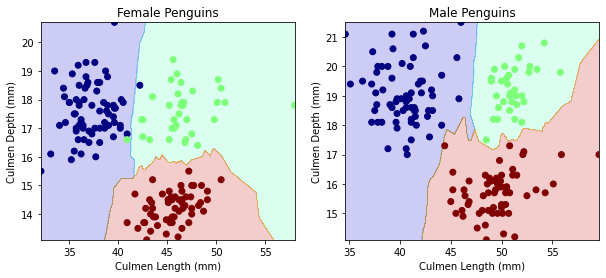

In [101]:
#split the original penguins dataset into:
#X(predictor variables with all columns) and y(target variable with "Species")
X,y=prep_penguins_data(penguins)
X3=X[best_combo]
plot_regions(KNN,X3,y)

By observing the two graphs above, we could tell that our model has a high accuracy that it has successfully predicted the species of most penguins.

In addition, we observed there is an apparent difference between female and male penguins: female penguins generally have smaller culmen depths and culmen lengths than male penguins. Also, ___culmen depth___ and ___culmen length___ are both good predictors for species, as we could tell from the clear borders between different color blocks.

## §4. Discussion

For all three models, we were able to achieve pretty satisfying results: Our __Decision Tree model__ was able to predict the test data with a 0.953125 accuracy; And both of our __Multinomial Logistic Regression model__ and __K-Nearest Neighbor model__ were able to predict with a 1.0 accuracy in our test data. However, we think we could improve the models by getting a larger data set, so we could have more training data and test data that can better reflect the ability of our models. With more data being available, we could train our model to get higher accuracies and avoid overfitting.

Overall, we would like to recommend the __K-Nearest Neighbor model__ to interpret the Palmer Penguin dataset for the following reasons: first of all, it is able to achieve a 1.0 accuracy on the test data. Secondly, by observing the confusion matrix, we did not find any wrong predictions, which shows that KNN model is superior in predicting the penguin data compared to other two models. This might due to the fact that the KNN model itself is very good at predicting data with a small size of predicators.

Even though we got pretty high accuracy in our model predictions, we still think there might be potential problems while implementing the three models in other settings.

First of all, we believe there are several possible dangers of using a __Decision Tree model__ for prediction. Since the Decision Tree model predicts the value of a target variable by following a set of simple decision rules based on its own analysis, a small change in the dataset may in turn causes a large change in the structure of the decision tree. This will usually result in instability. Moreover, while we were finding the best parameters in multiple runs, we got very different max_depths with all of them having very high accuracy. This indicates that Decision Tree models sometimes can have far more complex calculations than necessary compared to other algorithms.

While using __Logistic Regression models__ in other data sets, potential flaws might come from its inability to match all types of data set. For example, it inherently runs on a linear model, which would bring more restrictions when encountering a non-linear problem. In these situations, we might want to find other models that can better predict the data.

Lastly, although the __K-Nearest Neighbor model__ had a high accuracy on predicting our test data, it also has some disadvantages when applying to other datasets. The KNN model is sensitive and its accuracy highly depends on the quality of the data. The scale of the data and irrelevant features might cause the KNN model to produce erroneous predictions. Also, the KNN model requires large storage space, which can be computationally expensive.